# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [412]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [413]:
# Useful imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os #enable to read all files in doc automatically
sns.set_context('notebook')

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

# Answer Comentary:

As all the csv files are structured in very different ways, and contain various types of parsing errors, we cleaned all data for each country individualy before merging it into one dataframe. <br/>

General explination for all the steps:

1. We import the relevant columns -that is date, the variable name descripting the numbers in the rows and total number of affected cases-  of data from each folder. 

2. We remove any duplicates along the 'variable/description' column (if we have two 'new death' rows in one file we just decided to drop the second one, the values aren't identical but similar enough. Alternatively we could have taken the mean of the values with the same description)

3. We find the appropriate data rows in each file representing 'new cases' and 'new deaths' (we choose new deaths as we weren't 100% clear. However, it makes more sense to compare new cases with new deaths). Idealy, this would be just one row per file and type (case or death). However, in some countries total new cases/deaths aren't present. We then take the sum over the different types (suspected, probable and confirmed).

4. In the Sierra Leone dataset, there is no variable directly counting the number of new deaths, which is why we took the difference between the total number of deaths between two assessment days. In theory those two values should match up, but through tests we noticed that for our dataset this is not the case and the numbers are always slightly off (but not by a lot). The total number of deaths also decreases and has two two outlying spikes, which we remove as we assume that there are erroneous.

5. We create a frame that has a column for the date, the number of deaths and the number of cases. We make sure that in the end we have one entry for deaths and cases per file, as if this not the case, we must have made a mistake in the way we treat the data.

6. Plotting the data we notice that in Liberia we suddenly have a jump from ca 50 cases a day to +7000 a day-> someone must have made an error when writing the csv. We see that this value matches the total data from other days...and hence apply the same method used in 4. to get an approximation for the actualy daliy values. We also note that there is no data given for 'new deaths' in the days of decemeber. We could epproximate those again by taking the differences in deaths for the month of decemeber, but this would require extra DataFrame and extra manipulations (for data that is not that good of an approximation).

7. For each country we create a column to specify the country (later to be transformed into multi-index) and set the value in the date column to the month

8. We concatenate all the dataframes from all the countries and set the country as multi-index

9. We group the dataframe by date (which is now equal to the month) and country, and calculate the mean.

10. We now have the means daily means of new cases and deaths per country 



**N.B.** : For clarity, we will only comment the code for the 3 data cleaning parts once for steps that are repeated

In [414]:
path = DATA_FOLDER + '/ebola/'

#I procede to go through each folder, starting with Guinea
guinea_frame = pd.DataFrame()

for filename in os.listdir(path + 'guinea_data'):
    frame = pd.read_csv(path + 'guinea_data/' + filename, parse_dates=['Date'],
                        usecols = ['Date', 'Description', 'Totals']) #Keep only the 3 relevant colums
    
    #We are only interested in the New Deaths Registered or New Deaths Registered Today, the other lines are
    #not relevant for our analysis
    deaths = frame[[(d in 'New deaths registered') or (d in 'New deaths registered today') for d in frame.Description]
                  ][['Date', 'Totals']]
    deaths.columns = ['Date', 'Deaths'] #Renaming for convenience
    
    cases = frame[['Total new cases' in d for d in frame.Description]][['Date', 'Totals']]
    cases.columns = ['Date', 'Cases'] #Renaming for convenience
    
    #Make sure that we get the same number of values per file (one row per date/csv file)
    if(cases.shape != deaths.shape):
        raise AssertionError 
    
    total = pd.merge(deaths, cases, on='Date', how = 'inner')
    guinea_frame = guinea_frame.append(total) #Aggregate all csv files

guinea_frame['Country'] = 'Guinea'
#Make sure we get some data from every document & we don't miss rows
print('Getting all rows : ',
      guinea_frame.Deaths.shape[0] == len(os.listdir(path + 'guinea_data')))

Getting all rows :  True


The next part treats the data from Liberia. Overall, the transcription contains a lot of inconsistencies,
which were adressed by treating cases seperately

In [415]:
liberia_frame = pd.DataFrame()

tt = pd.DataFrame()

for filename in os.listdir(path + 'liberia_data'):
    frame = pd.read_csv(path + 'liberia_data/' + filename, parse_dates=['Date'],
                       usecols=['Date', 'Variable', 'National'])
    
    #There is a csv containing duplicates on the variable columns
    #As the values differ, I assumed that the first value is the correct one
    frame = frame.drop_duplicates(subset='Variable') 
    
    deaths = frame[[d in 'Newly reported deaths' for d in frame.Variable]][['Date', 'National']]
    deaths.columns = ['Date', 'Deaths']
    
    ##to show the difference later....not using this in the actual dataframe
    tt = tt.append(frame[['Total death/s in confirmed,' in d for d in frame.Variable]])
    
    #We get all 3 values of new cases (suspected, probable and confirmed) & sum them up
    cases_int = frame[['New Case/s'.lower() in d.lower() for d in frame.Variable]][['Date', 'National']]  
    cases_int.columns = ['Date', 'Cases']
    cases = cases_int.groupby('Date', as_index = False)['Cases'].sum()
    
    if(cases.shape != deaths.shape):
        raise AssertionError
    
    total = pd.merge(deaths, cases, on = 'Date', how = 'inner')  
    liberia_frame = liberia_frame.append(total)
    
#In December, the total cases & new cases are exchanged and no values for the new cases are provided
#We approximate those values by taking the difference of total values over multiple dates
liberia_frame.loc[(liberia_frame.Cases > 1000 ),'Cases'] =\
    liberia_frame[[d > 1000 for d in liberia_frame.Cases]]['Cases'].diff(periods=1)

liberia_frame['Country'] = 'Liberia'    


#######calculating extra stuff####
######just to show how dirty the data is D:
tt['Mean Deaths'] = tt['National'].astype(float).diff(periods=1)

total = pd.merge(liberia_frame, tt, on='Date')
total[total.National < 0] = float('nan')
total['Date'] = total['Date'].map(lambda x : x.month)

print('Here we show the differences in mean between new deaths and total death1 - total death2 : ')
print(total.groupby('Date').mean()[['Deaths', 'Mean Deaths']])

print('Getting all rows : ' , 
      liberia_frame.Deaths.shape[0] == len(os.listdir(path + 'liberia_data')))

Here we show the differences in mean between new deaths and total death1 - total death2 : 
         Deaths  Mean Deaths
Date                        
6      2.000000     5.500000
7      4.272727     8.727273
8     23.222222    82.222222
9     37.608696    46.863636
10    28.040000    26.173913
11    15.538462  -101.615385
12          NaN    14.777778
Getting all rows :  True


The final part of data cleaning is dedicated to the Sierra Leone files

In [416]:
sl_frame = pd.DataFrame()

for filename in os.listdir(path + 'sl_data'):
    frame = pd.read_csv(path + 'sl_data/' + filename, parse_dates=['date'],
                       usecols=['date', 'variable', 'National'])
    
    #These csv files do not count the number of new cases
    #We find an approximate value by taking the difference between two consecutive days registered
    deaths = frame[[d in ['death_suspected','death_probable','death_confirmed' ]
                    for d in frame.variable]][['date', 'variable', 'National']]

    deaths.National = deaths.National.astype(float) #Needed to deal well with nan values
    deaths = deaths.groupby('date', as_index = False)['National'].sum() #Summing over 3 possible types of death
    deaths.columns = ['Date', 'Total Deaths']
    
    cases = frame[[d in ['new_suspected','new_probable','new_confirmed' ]
                    for d in frame.variable]][['date', 'variable', 'National']]
    
    cases.dropna(axis='rows') #Dealing with na values, needed for the next step
    cases.National = cases.National.map(
        lambda x: x if type(x) is float else x.replace(',', '')) #If the string contains ','; remove it
    cases.National = cases.National.astype(float) #Needed to sum
    cases = cases.groupby('date', as_index = False)['National'].sum()
    cases.columns = ['Date', 'Cases']
    
    if(cases.shape != deaths.shape):
        raise AssertionError
    
    total = pd.merge(deaths, cases, on = 'Date', how = 'inner')  
    sl_frame = sl_frame.append(total) 

sl_frame.reset_index(drop = True, inplace = True)
new_deaths = sl_frame['Total Deaths'].diff(periods=1) 
sl_frame['Deaths'] = new_deaths #Set the new deaths
del sl_frame['Total Deaths'] #Drop the Total Deaths (not needed for our element)

sl_frame.loc[((sl_frame.Deaths < 0)), 'Deaths'] = float('nan') #Clearly we can't have negative deaths
sl_frame.loc[((sl_frame.Deaths > 200)), 'Deaths'] = float('nan')#We drop the strong outliers (2)

sl_frame['Country'] = 'Sierra Leone'

print('Getting all rows : ' , 
    sl_frame.Cases.shape[0] == len(os.listdir(path + 'sl_data')))

Getting all rows :  True


Now that we have clean values for all three countries, we can easily put them together and calculate the means

In [417]:
#MERGING ALL FRAMES
ebola_deaths_cases = pd.concat([guinea_frame, liberia_frame, sl_frame]).reset_index(drop = True)
ebola_deaths_cases['Date'] = ebola_deaths_cases['Date'].map(lambda x : x.month) ##change days to month
ebola_deaths_cases.Deaths = ebola_deaths_cases.Deaths.astype(float)
ebola_deaths_cases.Cases = ebola_deaths_cases.Cases.astype(float)
means = ebola_deaths_cases.groupby(['Date', 'Country'], as_index = False)[['Deaths', 'Cases']].mean()

#We are asked to calculate the means, we sort them for convenience
means.sort_values(by='Country', ascending = 1).set_index(['Country', 'Date'])

Deaths      Cases
Country      Date                      
Guinea       8      3.400000  25.800000
             9      3.562500  19.625000
             10    15.000000  34.000000
Liberia      6      2.000000   5.714286
             7      4.272727   8.545455
             8     23.222222  37.222222
             9     37.608696  63.833333
             10    28.040000  45.560000
             11    15.538462  26.466667
             12          NaN  21.142857
Sierra Leone 8      6.800000  27.944444
             9      5.120000  43.703704
             10    13.760000  70.928571
             11    21.058824  83.157895
             12    53.000000  68.333333

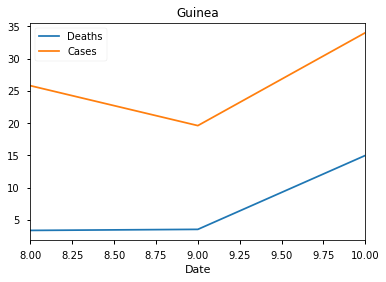

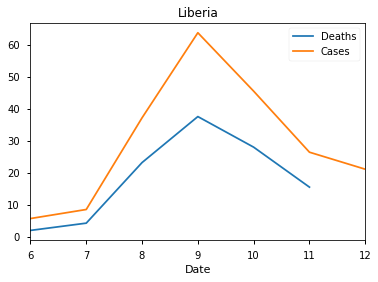

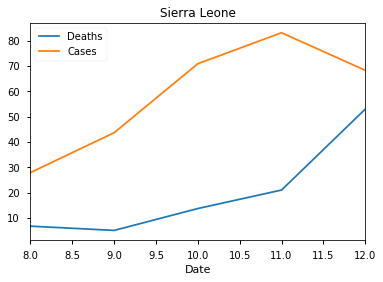

In [418]:
#Some figures (for fun!) used to visualize our data and make sure the results are consistent
# we can also see that new deaths and new cases seem correlated  ... this makes sense!
plt.figure();
grouped_means = means.groupby('Country')
grouped_means.get_group('Guinea').plot(x = 'Date', title = 'Guinea')
grouped_means.get_group('Liberia').plot(x = 'Date', title = 'Liberia')
grouped_means.get_group('Sierra Leone').plot(x = 'Date', title = 'Sierra Leone')

BONUS answer: 
to make sure the 'cleaned' data makes sense (no negative deaths or cases etc.) I used a simple bar graphs to check at one glance

Country
Guinea          Axes(0.125,0.125;0.775x0.755)
Liberia         Axes(0.125,0.125;0.775x0.755)
Sierra Leone    Axes(0.125,0.125;0.775x0.755)
dtype: object

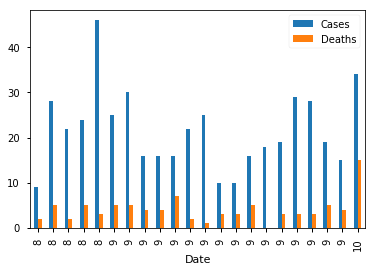

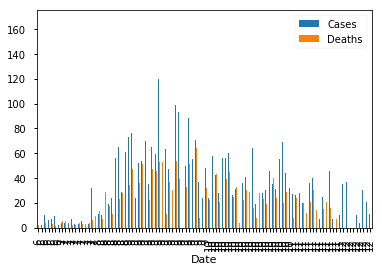

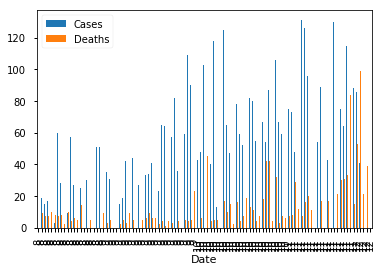

In [419]:
ebola_deaths_cases.groupby('Country').plot(x='Date', kind='bar')

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

# Answer Comentary:

The idea for the first part of this exercise is to merge all the files and to name each column imported using the namefile (it will be easier to tag all columns using the barcode at the end).

In [420]:
aggregated_frame = pd.DataFrame() # Creation of the aggregate (as in the exercises)
aggregated_frame.index.name = 'Taxon' # Tagging the index to be able to join the frames

for i in range(1, 10):
    filename = 'MID' + str(i) # Defined as a variable to be able to tag the columns
    temp_frame = pd.read_excel(DATA_FOLDER + '/microbiome/' + filename + '.xls','Sheet 1', index_col=0, header=None)
    temp_frame.columns = [filename]
    temp_frame.index.name = 'Taxon'
    aggregated_frame = aggregated_frame.join(temp_frame, how='outer') #Joining frames
    
aggregated_frame.head() #Show intermediate DataFrame

,MID1,MID2,MID3,MID4,MID5,MID6,MID7,MID8,MID9
Taxon,,,,,,,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",NaN,2.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",NaN,14.0,15.0,NaN,26.0,NaN,1.0,NaN,1.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7.0,23.0,14.0,2.0,28.0,7.0,8.0,NaN,16.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",NaN,1.0,4.0,NaN,5.0,1.0,2.0,NaN,2.0


In the second part, we import the Metadata (and clean it) before merging it in the third part

In [421]:
metadata = pd.read_excel(DATA_FOLDER + '/microbiome/metadata.xls','Sheet1', index_col=0)
metadata = metadata.fillna('NA') #As the 'NA' is translated to 'NaN', we decided to name 'NA' as to differentiate it
                                    #from the unknown objects and stick with the metadata
metadata

,GROUP,SAMPLE
BARCODE,,
MID1,EXTRACTION CONTROL,NA
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


In the final part, we group the elements by the values given in the metadata file and replace the NaN values

In [422]:
aggregated_frame = aggregated_frame.T.join(metadata) #Allows us to easily join with metadata
final_frame = aggregated_frame.set_index(['SAMPLE', 'GROUP']).T #We group the elements and obtain the desired shape
final_frame = final_frame.fillna('unknown') #This is the last step as required
final_frame.head() #Display part of final frame

SAMPLE                                                             NA  \
GROUP                                              EXTRACTION CONTROL   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  7   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   

SAMPLE                                               tissue            \
GROUP                                                 NEC 1 Control 1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...        2         1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...       14        15   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       23        14   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1         4   

SAMPLE                                                                 \
GROUP                                                 NEC 2 Control 2   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         5   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown        26   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        2        28   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         5   

SAMPLE                                                stool            \
GROUP                                                 NEC 1 Control 1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        7         8   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1         2   

SAMPLE                                                                 
GROUP                                                 NEC 2 Control 2  
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown   unknown  
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         1  
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown        16  
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown  
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         2

In [423]:
#as required
final_frame.index.is_unique

True

### Notes:

1. Instead of iterating on the indexes each file, we could use the barcode of the metadata to iterate over each file and give the possibility to add more files without having to change the code
2. We did not know if we should have tagged the 'NA' value in the SAMPLE column as 'unkwown' or if we should have kept the name, so we decided to stick with the name
3. To group the elements, we thought it best to define the SAMPLE as the supergroup as it contained more columns than the GROUP (easier visualization), but it is easy to change them and order them according to each group.
4. If there is an error on a field in this question, please just reload the frames above before the error and try again.

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [424]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

# Importing the xls file
titanicXls = pd.read_excel(DATA_FOLDER+'/titanic.xls', header=0)
# See what the data looks like
titanicXls.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

- Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

## Answers

For question 1:

Let's go in order for each column :
0. Pclass is the level they were on: either first, second or third class [1, 2, 3].
1. Survived, which can take either 0 or 1 (so yes or no).
2. Name which can take any string. Begins with a last name, then a comma, than the title (Miss, Mr. Master...) and the first name(s).
3. Sex, which can be either male or female.
4. Age, which can take any number (double).
5. Sibsp is the number of siblings aboard of the titanic and can take any integer.
6. Parch is the number of parents aboard of the titanic and can take any integer.
7. Ticket which is the ticket number. Can take any integer, sometimes preceded with letters. Several members of a same family can share one.
8. Fare, which is the amount paid for the ticket (double). Defacto fixied pricing, but as one person can pay for multiple tickets, there is no fixed number of categories.
9. Cabin which contains the cabin letter and number. Can have several of them per entry.
10. Embarked is where someone has embarked and can take the initials S, C or Q.
11. Boat which is the escape boat they were on. Can either be an integer, a character, a mix of both or NaN (usually if survived = 0).
12. Body which is either a number or NaN. Represent if the body was found and if it was, which number (body indentification number) it was. 
13. Home.dest is the destination there were going to. Can take any string (addresses).
(Note that all these informations can be found in the html file).



We first answer using the statistical meaning of categorical variable. \*Pandas uses a slightly different definition than the general meaning, where categorical data can be ordered.

We can determine which attributes are *Categorical* knowing that they are anything with a fixed number of categories that do not have an intrinsic ordering.
Thus, clearly <font color='red'>pclass, survived, sex, cabin, embarked and boat</font> are all categorical.
<font color='blue'>Cabin</font> has many distinct values, thus it may not be ideal to transform it into categorical data for so little rows.

Home.dest could be considered to be categorical in certain circumstances (all people come from a certain fixed number of towns). However, it does not make much sense to transform this variable in our case, as there are so many different cities present in the dataset. 
If we only had states from the USA (as there is a fixed number of them) it would could make more sense, but it is harder to transform seeing as we have other destinations (like Canada or France).

Ticket, body, name, fare are not part of categorical data, as adding a new element to the set will likely lead to a new 'category' for each of those entries, hence the number of categories isn't fixed. 

Transforming all categorical data using pandas:

In [425]:
#we rename class to have prettier charts and more human redable rows
titanicXls['pclass'] = titanicXls['pclass'].map({1: 'First Class', 2: 'Second Class', 3: 'Third Class'}).astype('category')
titanicXls['survied'] = titanicXls['survived'].astype('category')
titanicXls['sex'] = titanicXls['sex'].astype('category')
titanicXls['cabin'] = titanicXls['cabin'].astype('category')
titanicXls['embarked'] = titanicXls['embarked'].astype('category')
titanicXls['boat'] = titanicXls['boat'].astype('category')

- Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*.

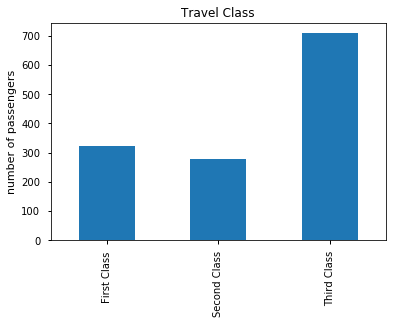

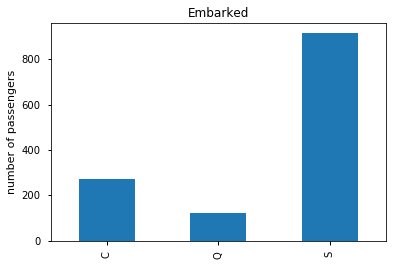

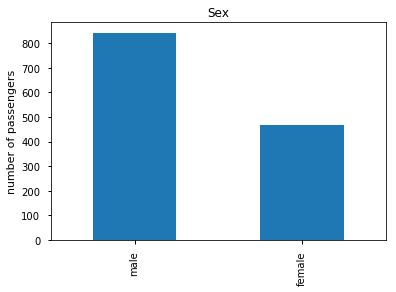

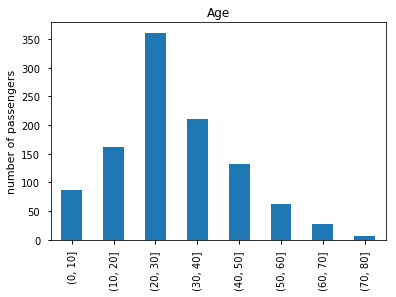

In [426]:
#  We can simply count all the pclass values by category and plot them
plt.title('Travel Class')
titanicXls.pclass.value_counts().sort_index().plot(kind='bar').set_ylabel("number of passengers")
plt.show()

#for embarked and sex, we need to have bar charts, as we do not have numerical values.
plt.title('Embarked')
titanicXls.embarked.value_counts(sort=False).sort_index().plot(kind='bar').set_ylabel("number of passengers")
plt.show()

plt.title('Sex')
titanicXls.sex.value_counts().plot(kind='bar').set_ylabel("number of passengers")
plt.show()

# Histogram does the work for us.
#we first discretize the data
#titanicXls.age.describe() gives that min is 0 and max is 80
titaic_ages = pd.cut(titanicXls.age, np.arange(0, 90, 10))
plt.title('Age')
titaic_ages.value_counts(sort=False).plot(kind='bar').set_ylabel("number of passengers")
plt.show()

- Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

I take in consideration that each floor is the first character (A to G + T) and only take into account the first character as the floor. This is justified as only very few cabins listed are on different floors, as can be seen in the next small calculation. we can thus say that these few outliers will not affect the pie chart. We assume that T is an actual deck, it probably corresponds to the  the 'Tank top' see http://www.titanicandco.com/inside.html 

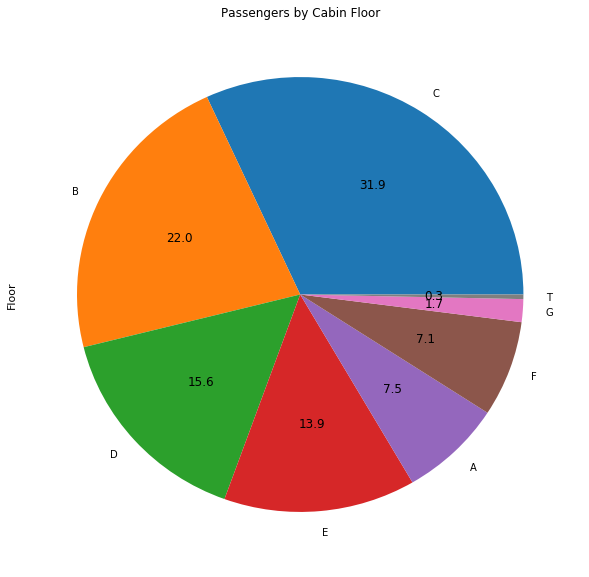

In [427]:
# Clean the NaN
cabins = pd.DataFrame(titanicXls.cabin.dropna())
# Determine the floor for each row
cabins['Floor'] = cabins['cabin'].str[:1]
#Plot the values.
plt.title('Passengers by Cabin Floor')
cabins['Floor'].value_counts().plot.pie(figsize=(10, 10), autopct='%.1f')
plt.show()

In [428]:
##small preliminary verificaton...
types_of_cabin = pd.DataFrame(titanicXls.cabin.value_counts()).index
types = types_of_cabin.map(lambda x: ''.join([c for c in x if c.isalpha()]))
types.map(lambda x: len(list(set(x)))).value_counts() # we can see that we only have 5 cabins were the deck is not equal...

1    181
2      5
dtype: int64

- For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

I take into consideration that 1 is a yes for survived.

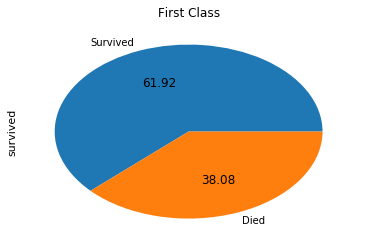

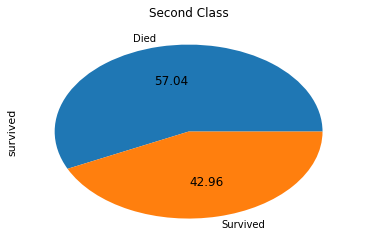

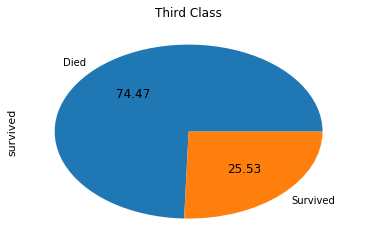

In [429]:
# Take only the interesting columns (survived & pclass)
survivalByClass = titanicXls.iloc[:, 0:2]
# Clean it from the NaN
survivalByClass = pd.DataFrame(survivalByClass.dropna())

##manualy label because I haven't figured out a better way :(
survivalByClass.groupby('pclass').survived.value_counts()['First Class'].plot.pie(title='First Class', 
                            autopct='%.2f', labels=['Survived','Died'])
plt.show()
##manualy label because I haven't figured out a better way :(
survivalByClass.groupby('pclass').survived.value_counts()['Second Class'].plot.pie(title='Second Class',
                            autopct='%.2f', labels=['Died','Survived'])
plt.show()
survivalByClass.groupby('pclass').survived.value_counts()['Third Class'].plot.pie(title='Third Class',
                            autopct='%.2f', labels=['Died','Survived'])

- Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

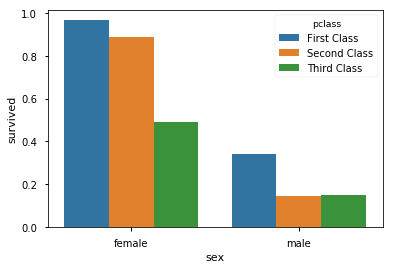

In [430]:
# Take only the interesting columns = sex & class & survived
survivalBySex = titanicXls.iloc[:, [0,1,3]]
# Take out all NaN
survivalBySex = pd.DataFrame(survivalBySex.dropna())

# Take only those that survived
#as survived takes 0 and 1 the proportion is equal to the mean
survivedSex = titanicXls.groupby(['sex', 'pclass'], as_index=False)['survived'].mean()

sns.barplot(x="sex", y="survived", hue="pclass", data=survivedSex);


- Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.


Answer commentary: we named the age categories by mean, just for clarity


In [431]:
# Take only the interesting columns
survivalByAge = titanicXls.iloc[:, [0,1,3,4]]
# Take out all NaN
survivalByAge = pd.DataFrame(survivalByAge.dropna())
# Sort by Age
survivalByAge = survivalByAge.sort_values('age')

# We have 1046 rows in this DataFrame. Thus, the 523 first rows are the first category. The 523 last are the second.
# Lets thus replace the age of everyone by 1 for the first category and 2 for the second.
# As category we will put the mean age of the category.
n = len(survivalByAge)
survivalByAge.loc[:n/2, 'age'] = survivalByAge.loc[:n/2, 'age'].mean()
survivalByAge.loc[(n/2):, 'age'] = survivalByAge.loc[(n/2):, 'age'].mean()

# This will do the mean for each group/category we want, as we have only 0 or 1.
groupedSurvival = survivalByAge.groupby(['age', 'sex', 'pclass'])['survived'].mean()
survivalByAgeDF = pd.DataFrame(groupedSurvival)

#Checking that index is indeed unique: it is
print('index is unique : ', survivalByAgeDF.index.is_unique)

survivalByAgeDF

index is unique :  True


survived
age       sex    pclass                
14.513398 female First Class   0.954545
                 Second Class  0.939394
                 Third Class   0.480000
          male   First Class   0.538462
                 Second Class  0.382353
                 Third Class   0.187970
36.353958 female First Class   0.963964
                 Second Class  0.871429
                 Third Class   0.467532
          male   First Class   0.333333
                 Second Class  0.080645
                 Third Class   0.157407